<div style="vertical-align:middle">
<img width="170" style="float: right;" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/EU_Informatica/ETSI%20SIST_INFORM_COLOR.png" alt="ETSISI logo" />
<h1>Controladores borrosos para el control de la ventilación<a id="top"></a></h1>
<i><small>Fuentes: <a href="https://github.com/etsisi/Robotica">github.com/etsisi/Robotica</a><br>Última actualización: 2023-10-21</i>
</div>
<hr>

## Introducción

La lógica borrosa es una extensión de la lógica booleana tradicional que fue introducida por Lotfi A. Zadeh en la década de 1960. A diferencia de la lógica booleana, que opera en valores absolutos de verdadero o falso (1 o 0), la lógica borrosa permite trabajar con grados de verdad, que pueden variar entre 0 y 1. Esta capacidad de manejar la incertidumbre y la ambigüedad hace que la lógica borrosa sea especialmente adecuada para situaciones en las que las decisiones no se pueden basar en datos precisos o cuando las categorizaciones claras son difíciles de establecer.

El control borroso, una aplicación directa de la lógica borrosa, es un método de toma de decisiones y control que utiliza conjuntos borrosos y un sistema de reglas borrosas para determinar un resultado o acción. A diferencia de los sistemas de control tradicionales, que suelen basarse en ecuaciones matemáticas y modelos precisos, los controladores borrosos se basan en "reglas lingüísticas" o declaraciones cualitativas sobre cómo operar. Estas reglas, aunque imprecisas, suelen ser más intuitivas y más cercanas a la forma en que los humanos toman decisiones.

En un contexto post-apocalíptico, la adaptabilidad y la toma de decisiones en condiciones inciertas son esenciales para la supervivencia. Es un entorno ideal para explorar cómo el control borroso puede ser una herramienta vital para gestionar sistemas críticos.

## Objetivos

Durante este notebook cubriremos los siguientes objetivos:

1. Introducir los conceptos fundamentales de la lógica y el control borroso
2. Aplicar el control borroso a un problema práctico dentro del universo de Fallout
3. Demostrar la utilidad del control borroso en sistemas de lazo cerrado.

Y no se nos ocurre un escenario más realista que el universo Fallout. ¡Comenzamos!

## Bibliotecas y configuración

Comenzaremos instalando las bibliotecas necesarias. Esto sólo es necesario en el caso de que no tengamos el entorno ya creado.

In [4]:
!pip install matplotlib
!pip install numpy
!pip install scikit-fuzzy


[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: pip install --upgrade pip


A continuación importaremos las bibliotecas que se utilizarán a lo largo del notebook.

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

Forzamos algunos parámetros de configuración.

In [8]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams.update({'figure.figsize': (20, 6),'figure.dpi': 64})

***

## Descripción del problema

Tras el devastador cataclismo nuclear, el entorno externo se transformó en un yermo tóxico y desolado. Las antiguas metrópolis, ahora en ruinas, y los vastos desiertos cargados de radiación se encuentran impregnados de gases letales y partículas contaminantes en el aire, convirtiendo la atmósfera exterior en un peligro constante.

Los refugios subterráneos surgieron como bastiones de esperanza, diseñados meticulosamente para proteger a sus ocupantes de las innumerables amenazas del exterior. Uno de los componentes más vitales de estos refugios es el sistema de ventilación, encargado no solo de suministrar oxígeno fresco, sino también de filtrar y neutralizar cualquier toxina o contaminante. No obstante, la naturaleza impredecible de este mundo post-apocalíptico presenta un desafío: en ocasiones, el aire exterior puede ser relativamente limpio, mientras que en otros momentos, puede estar saturado de tóxicos. Este carácter volátil y las posibles imprecisiones de los sistemas de medición tradicionales pueden llevar a decisiones subóptimas en cuanto a la ventilación.

Es en este contexto que el control borroso cobra protagonismo. En vez de confiar exclusivamente en sensores de alta precisión y en puntos de ajuste fijos, el sistema de ventilación podría beneficiarse de una lógica borrosa. Esta lógica permitiría interpretar la calidad del aire mediante categorías más amplias, como 'Buena', 'Regular' y 'Mala'. Sumado a esto, es esencial considerar el número de ocupantes en el refugio, ya que no es lo mismo tener 10 personas respirando que 100. Por ello, se podrían utilizar categorías como 'Pocos', 'Moderado' y 'Muchos' para determinar el número de habitantes presentes. A partir de estas evaluaciones, el sistema podría ajustar adecuadamente el nivel de ventilación, optando por 'Bajo', 'Medio' o 'Alto'. Este sistema borroso, con su capacidad para tomar decisiones basadas en datos imprecisos o incompletos, garantiza que el aire dentro del refugio sea siempre seguro y respirable para sus habitantes.

## Desarrollo

### Definición de las variables lingüísticas

En nuestro problema usaremos tres variables lingüísticas, dos de entrada o **antecedentes** y una de salida o **consecuente**: (nivel de ventilación):

- **Calidad del aire**, que puede ser `Buena` (niveles bajos de contaminantes y gases tóxicos, de $0$ a $50$, `Regular` (niveles moderados, de $50$ a $80$) o `Mala` (de $80$ a $100$).
- **Cantidad de personas**, que suponiendo que un refugio puede albergar a 200 personas, pueden ser `Pocos` (de $0$ a $50$), `Moderado` (de $50$ a $150$) o `Muchos` (de $150$ a $200$).
- **Nivel de ventilación**, que puede corresponderse a `Bajo` (un flujo de aire reducido, de $0$ a $33\%$), `Medio` (un flujo intermedio, del $34\%$ al $66\%$) o `Alto` (un flujo acelerado, del $67\%$ al $100\%$

Nuestra biblioteca representará estas variables con objetos de las clases `Antecedent` o `Consequent`, dependiendo de si se tratan de variables lingüísticas de entrada o de salida. Éstas contendrán la información de su dominio de aplicación y de las funciones de pertenencia que caracterizan a sus conjuntos borrosos.

In [9]:
# Antecedentes
air_quality = ctrl.Antecedent(np.arange(0, 100, 0.01), 'Calidad del aire')
num_people = ctrl.Antecedent(np.arange(0, 200, 1), 'Cantidad de personas')
# Consecuente
air_flow = ctrl.Consequent(np.arange(0, 100, 0.01), 'Nivel de ventilación')

### Definición de las funciones de pertenencia

Las funciones de pertenencia caracterizan a los conjuntos borrosos, que serán los valores que pueden tomar esas variables lingüísticas en mayor o menor medida.

In [11]:
# Funciones de pertenencia para la calidad del aire
air_quality['good'] = fuzz.trimf(air_quality.universe, [0, 0, 50])
air_quality['regular'] = fuzz.trimf(air_quality.universe, [50, 65, 80])
air_quality['bad'] = fuzz.trimf(air_quality.universe, [80, 100, 100])
# Funciones de pertenencia para el número de personas
num_people['few'] = fuzz.trimf(num_people.universe, [0, 0, 50])
num_people['average'] = fuzz.trimf(num_people.universe, [50, 100, 150])
num_people['several'] = fuzz.trimf(num_people.universe, [150, 200, 200])
# Funciones de pertenencia para el nivel de ventilación
air_flow['low'] = fuzz.trimf(air_flow.universe, [0, 0, 33])
air_flow['medium'] = fuzz.trimf(air_flow.universe, [34, 50, 66])
air_flow['high'] = fuzz.trimf(air_flow.universe, [67, 100, 100])

Ahora veamos cómo han quedado las variables particionadas:

/home/blazaid/.cache/pypoetry/virtualenvs/notebooks-WUQkwkS2-py3.10/lib/python3.10/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


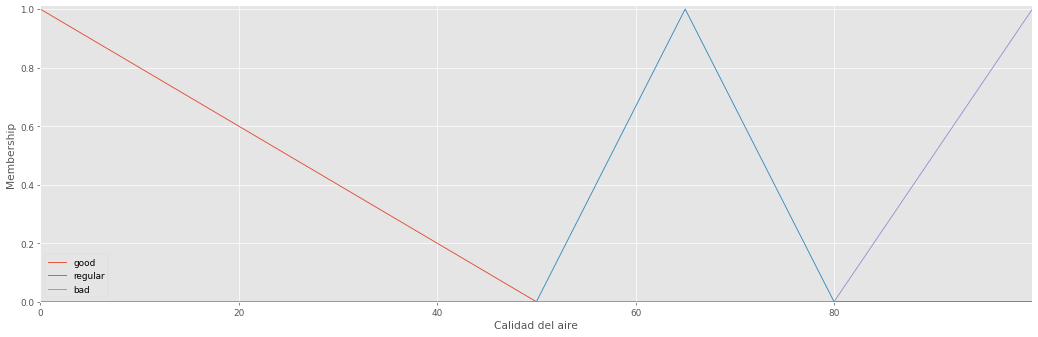

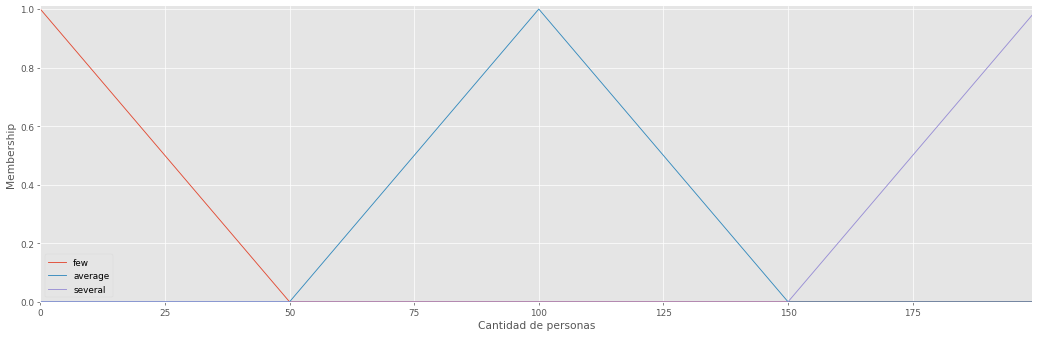

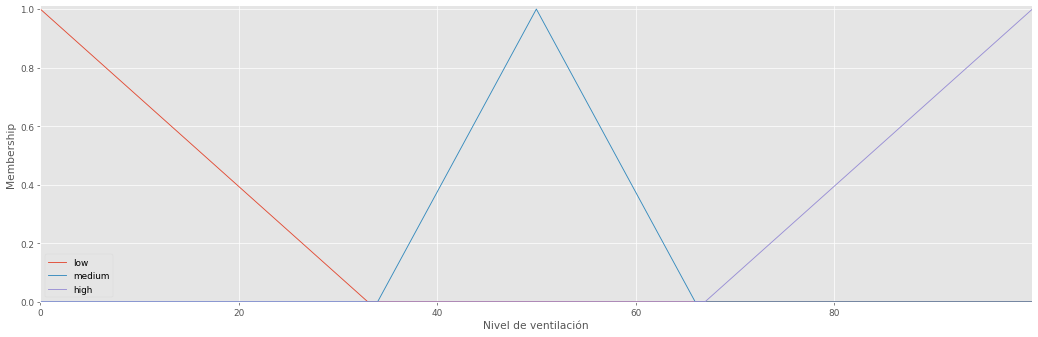

In [12]:
air_quality.view();
num_people.view();
air_flow.view();

### Reglas del controlador

Las reglas en este ejemplo son muy simple: relacionaremos cada ángulo directamente con la velocidad que tiene que tomar el carrito. Así, si está bastante escorado a la derecha, tendrá que aplicar bastante potencia al motor para que se desplace hacia la derecha.

In [14]:
rulebase = [
    ctrl.Rule(air_quality['good'] & num_people['few'], air_flow['low']),
    ctrl.Rule(air_quality['good'] & num_people['average'], air_flow['low']),
    ctrl.Rule(air_quality['good'] & num_people['several'], air_flow['medium']),
    ctrl.Rule(air_quality['regular'] & num_people['few'], air_flow['low']),
    ctrl.Rule(air_quality['regular'] & num_people['average'], air_flow['medium']),
    ctrl.Rule(air_quality['regular'] & num_people['several'], air_flow['high']),
    ctrl.Rule(air_quality['bad'] & num_people['few'], air_flow['medium']),
    ctrl.Rule(air_quality['bad'] & num_people['average'], air_flow['high']),
    ctrl.Rule(air_quality['bad'] & num_people['several'], air_flow['high']),
]

### Construcción del simulador y lanzamiento de la simulación

In [15]:
ventilation_ctrl = ctrl.ControlSystem(rulebase)
ventilation_simulation = ctrl.ControlSystemSimulation(ventilation_ctrl)

Con el simulador una vez creado, podemos alimentarle con valores para ver cuál sería la salida de nuestro controlador:

In [19]:
ventilation_simulation.input['Calidad del aire'] = 30
ventilation_simulation.input['Cantidad de personas'] = 100
ventilation_simulation.compute()
print(ventilation_simulation.output['Nivel de ventilación'])

13.475000000000163


Podemos además ver cual es la región activada en las variables de salida en función de las entradas (y las reglas activadas).

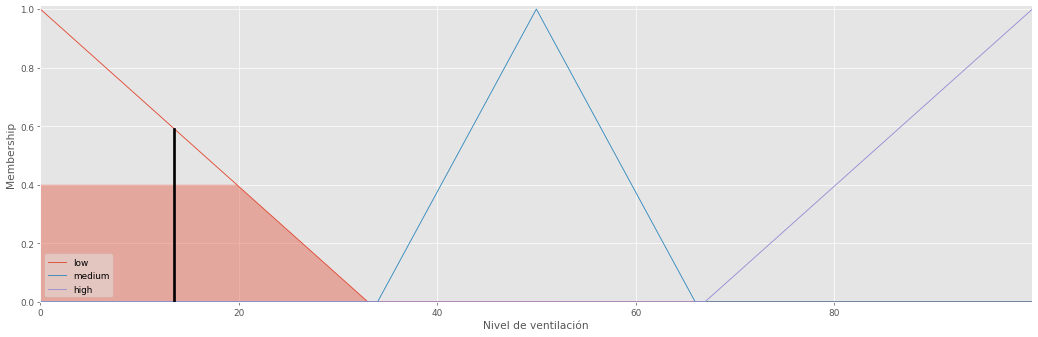

In [23]:
air_flow.view(sim=ventilation_simulation)

## Conclusiones

A través de este ejercicio, hemos visto cómo un controlador borroso puede ser diseñado para gestionar la ventilación en un escenario ficticio, proporcionando una herramienta poderosa para asegurar un ambiente habitable en el refugio. Esto demuestra la utilidad y la flexibilidad de la lógica borrosa en la toma de decisiones basada en múltiples factores en un entorno incierto y variable.

***

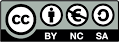

[Volver al inicio](#top)